### Measured and artificial map content comparison
This notebook compare via FT the content of a measured mirror map and an artificial map done with Zernike polynomials. We'll say 'measured' or 'real' when we speak about the measured mirror map, and 'virtual' or 'artificial' regard the reconstructed map.

The main idea is this, starting from a real mirror map of radius R:

- Create Zernike poynomials until order n, with radius R.
- Compute the $A_n$ coefficients to reproduce the real map as linear combination of the Zernike polynomials
- do a Fast Fourier Transformation (FFT) to compare the content in the real map and in the virtual_map
- Load maps into Finesse model and try modes content and such, to see maps comparison.

Remember that, given an **n** as radial index and **m** as azimuthal index, with $m\le n$, then we have:
\begin{eqnarray}
Z^{+m}_n(\rho,\phi)= \cos(m\phi)R^{m}_{n}(\rho)\,\,\,\,for\, even\, polynomials
\end{eqnarray}
\begin{eqnarray}
Z^{-m}_n(\rho,\phi)= \sin(m\phi)R^{m}_{n}(\rho) \,\,\,\,for\, odd\, polynomials
\end{eqnarray}
Where $R^{m}_{n}(\rho)$ is the radial function given by:

\begin{eqnarray}
R^{m}_{n}(\rho)=\sum^{\frac{1}{2}(n-m)}_{h=0}\frac{(-1)^{h}(n-h)!}{h!(\frac{1}{2}(n+m)-h)!(\frac{1}{2}(n-m)-h)!}\rho^{n-2h}  \,\,\,\,\, if\, (n-m)\,\, is\,\, even,\,\,and \,\,is\,\,0\,\,if\,\,(n-m)\,\, is\,\, odd. 
\end{eqnarray}

the A_n coefficients are computed with: 
\begin{eqnarray}
A_n = \frac{\sum_{x,y}Z_{map}\cdot Z_{n}^{m}(x,y)}{\sum_{x,y}Z_{n}^{m}(x,y)\cdot Z_{n}^{m}(x,y)}\,\,.
\end{eqnarray}
Where $Z_{map}$ is the measured mirror map 2D matrix description. So really the heighs of the mirror respect a flat one. 

<!--%%latex --> 
<!--%%latex --> 

In [1]:
import numpy as np
import pandas as pd               
from scipy.special import factorial
import fileinput
import matplotlib.pyplot as plt

# Step 1: create a base of Zernike polynomials
We use a function called Zernikes() tha will return a list [], each element is a eigenmode of Zernike polynomials.  
So we'll have:  
Z_basis = Zernikes(bla bla )

Z_basis[0] = n=0,m=0  
Z_basis[1] = n=1,m=1   
Z_basis[2] = n=1,m=-1  
Z_basis[3] = n=2,m=-2  
Z_basis[4] = n=2,m=0  
Z_basis[5] = n=2,m=2
.
.
.



In [2]:
# return a list of Zernike maps(basis) 
def Zernikes(shape, radius, max_zern): 
    '''
    shape = int, number of points of the real map that describe the mirror, like np.shape(x-axis). 
    radius = int, the radius will be the real mirror radius.  
    max_zern = int, the basis will be computed up to a max zarnike's order. 
    
    return= a list containing the Zernike basis 
    '''
    step_size = radius*2/shape
    center = (shape-1)/2 # Center of the map
    rrange = radius/step_size # it gives how many steps there are in a radius.
    zernikes=[] # list of Zernike maps
    
    # prep phi element
    def theta(x,y):
        phi = np.arctan2(y, x)
        return phi
    
    # prep radil part. 
    def radial(x,y,n,m):
        # we keep m positive just to compute the radial part.
        if m<0:
            m=-m
            
        # for each n,m couple the radial part is a sum of elements. 
        sum=0
        norm_rad = ((x**2+y**2) / rrange**2 ) **(1/2)   # normalizing the radius from a step point of view. 
        # radial component, we now collect all the radial parts, without apply the rule for (n-m) as odd value:
        for h in range(int((n-m)/2)+1):  
            # using step-normalized radius 
            r=((-1)**h) * (factorial(n-h)) / (factorial(h) * factorial((n+m)/2-h) * factorial((n-m)/2-h)) * ((norm_rad)**(n-2*h))
            # updating the sum                                                                                                
            sum+=r
        # return radial function                                                                                                   
        return sum
                                                                                                             
    # sin e cos parts of Zernike 
    def angular(x,y,n,m): 
        a=theta(x,y)
        if m>=0:
            angular=np.cos(m*a)
        else:
            angular=-np.sin(m*a)  # -sin(-beta) = sin(beta)
        return angular
                                                                                                             
    # for each n,  m should go from -n to n, excluding the values where n-m is odd, where the Zn are zero.
    for n in range(max_zern+1):
        # for each n,m a matrix is build  --------------------                                                                                                 
        for m in range(-n,n+1,2):   # selecting only n-m as even
            # we're centering around zero the Zernike polynomials.                                                                                               
            stepRange = np.arange(shape)-center 
            # prep grid, with sparse=True the matrices x and y will be reduced to a 1d array each. Using them together should make a new matrix?                                                                                                
            x,y=np.meshgrid(stepRange,stepRange,sparse=True)
            # z value in x,y position of the matrix                                                                                                
            zfunc=radial(x,y,n,m)*angular(x,y,n,m)
         #----------------------------------------------------------------
         # Set the values outside the radius to zero                                                                                                    
            for i in range(shape):
                for j in range(shape): 
                    if (i-center)**2+(j-center)**2 >= rrange**2:
                        zfunc[i][j]=0 
                 #------------------------------------------------------------------                                                                                             
            zmap=zfunc/np.abs(zfunc).max() # Such that the amplitude(maximum value in the map data) equals to 1
            zernikes.append(zmap)

    return zernikes # Return Zernike basis up to max_zern

### Testing the function with a low n index

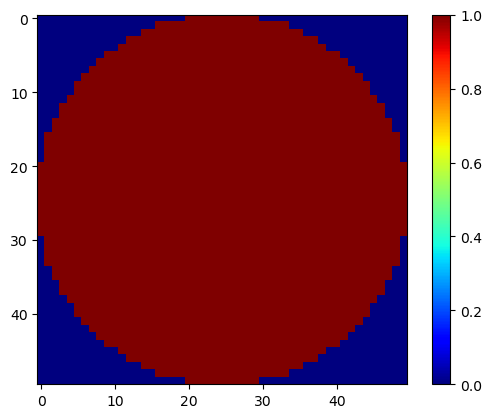

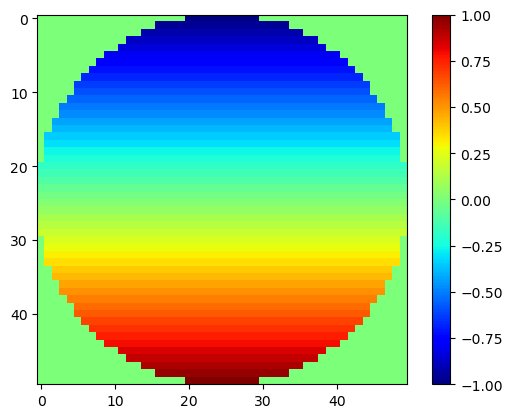

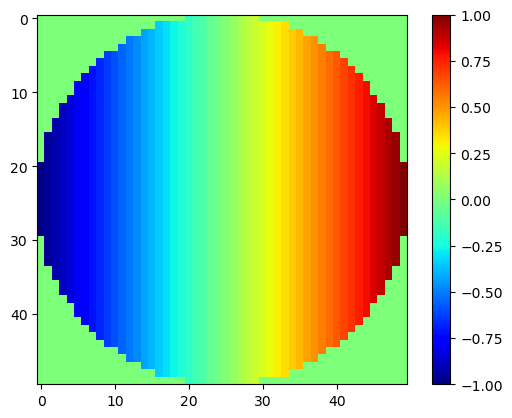

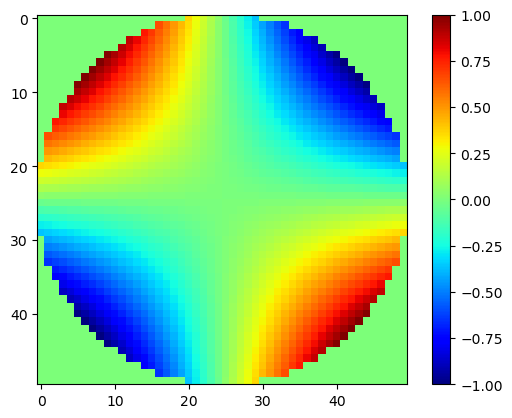

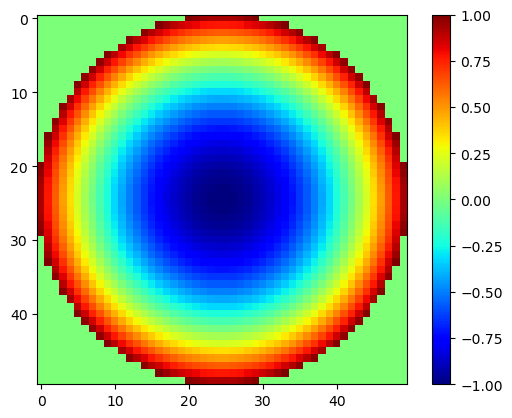

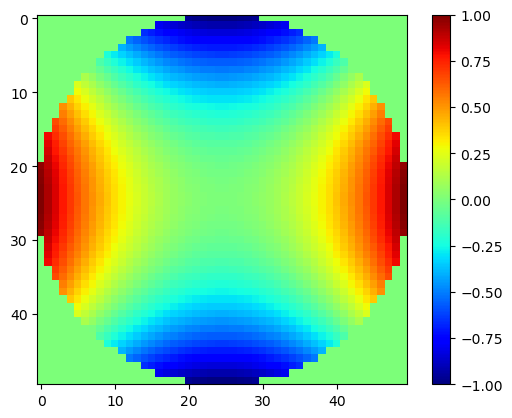

In [3]:
test = Zernikes(50,0.15,2)

for i in test:
    plt.figure()
    plt.set_cmap("jet")
    im = plt.imshow(i)
    plt.colorbar(im, orientation='vertical')
    plt.show()

# Step 2: computing the A_n coefficients given a measured map
We load a measued map and compute the $A_n$ coefficients to reproduce the map as a linear compbination of Zernike's modes. 

<!--%%latex --> 

In [4]:
# func to compute coeff
def coeff_An_zernike(real_map,zernikebasis):
    # coeff
    a_n = []
    
    for index,mode in enumerate(zernikebasis):
        a_n_ = (real_map*zernikebasis[index]).sum()/(zernikebasis[index]**2).sum()
        a_n.append(a_n_)
    # return the A_n coefficients
    return a_n

In [5]:
# plot A_n content
#mid_val_an = int(order/2)
def a_n_plot(coeff,order):
    fig,ax =plt.subplots(figsize=(20,8))
    fig.subplots_adjust(bottom=0.12, top=0.96, left=0.1, right=0.96)
    ax.plot(coeff, 'b', linewidth=2)

    # todo: split in 2 the plot for order over 8
    xticks = []
    for n in range(order):
        # for each n,m a matrix is build  --------------------                                                                                                 
        for m in range(-n,n+1,2):   # selecting only n-m as even
            xticks.append("$Z_{"+str(n)+"}^{"+str(m)+"}$")

    for n in range(order):
        for m in range(-n,n+1,2):
            ax.set_ylabel("A_n[nm]", fontsize=15)
            ax.set_xlabel(f"$Z^m_n $",fontsize=18)
            ax.set_xticks(range(len(xticks)))
            ax.set_xticklabels(xticks,rotation=45)

    # plt.savefig('decomposition.pdf')
    plt.show()

In [25]:
# load a file that represents the opd path in a mirror map. We expect it to be a 2D matrix
fname = 'ETM05_S1_finesse'
measured_map=pd.read_csv(f'{fname}.txt', header=None, sep=" ", skiprows=9).dropna(axis=1).values
# catch the shape
shape = np.shape(measured_map)[0]
# step size
size = 0.0002669951063580811
map_range = shape*size

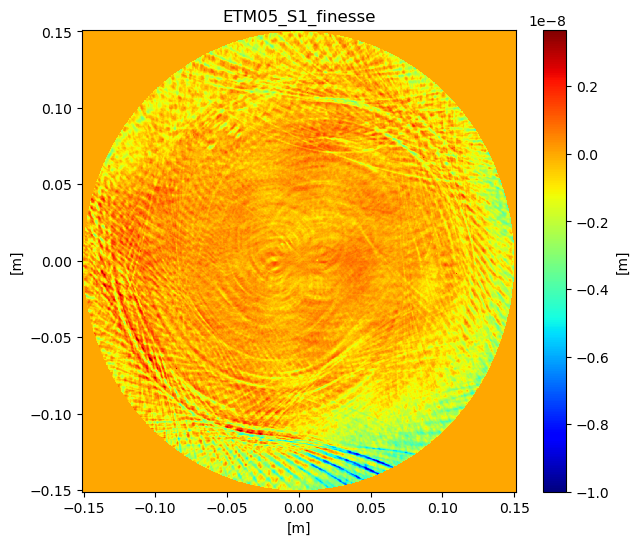

In [32]:
# recentering rand plot real map

# normalization to 1, as that max A_n is 1
m_map=measured_map/np.abs(measured_map).max()

x_range = np.linspace(-map_range/2,map_range/2,1131)                                                                                          
x,y=np.meshgrid(x_range,x_range,sparse=True)
# plot real map
plt.figure(figsize=(7,6))
plt.pcolormesh(x,y,m_map*1e-8,cmap='jet')
plt.xlabel('[m]')
plt.ylabel('[m]')
plt.title(f'{fname}')
# color bar
cb = plt.colorbar()                 
cb.set_label("[m]")   
plt.savefig('etm05.png')
plt.show()

In [8]:
# func to compute coeff
def coeff_An_zernike(real_map,zernikebasis):
    # coeff
    a_n = []
    
    for index,mode in enumerate(zernikebasis):
        a_n_ = (real_map*zernikebasis[index]).sum()/(zernikebasis[index]**2).sum()
        a_n.append(a_n_)
    # return the A_n coefficients
    return a_n

In [9]:
# collect the Zernike basis

#order, the a_n plot need to be splitted in 2 for high n order
order = 25

#basis
basis = Zernikes(1131,0.15,order)

# collect the A_n
a_n = coeff_An_zernike(measured_map,basis)

In [10]:
# plot A_n content
#mid_val_an = int(order/2)
def a_n_plot(coeff,order, split=False):
    xticks = []
    for n in range(order+1):
        # for each n,m a matrix is build  --------------------                                                                                                 
        for m in range(-n,n+1,2):   # selecting only n-m as even
            xticks.append("$Z_{"+str(n)+"}^{"+str(m)+"}$")

    def split_plot(ax, min, max, coeff, xticks):
        ax.plot(coeff[min:max+1], 'b', linewidth=2)
        
        ax.set_ylabel("A_n[nm]", fontsize=15)
        ax.set_xlabel(f"$Z^m_n $",fontsize=18)
        ax.set_xticks(range(len(xticks[min:max+1])))
        ax.set_xticklabels(xticks[min:max+1],rotation=45)

    if split:
        fig, (ax1, ax2) =plt.subplots(2,1,figsize=(20,8))
        fig.subplots_adjust(bottom=0.12, top=0.96, left=0.1, right=0.96)
        split_plot(ax1, 0, int(len(xticks)/2), coeff, xticks)
        split_plot(ax2, int(len(xticks)/2)+1, len(xticks), coeff, xticks)
    else:
        fig, ax =plt.subplots(figsize=(20,8))
        fig.subplots_adjust(bottom=0.12, top=0.96, left=0.1, right=0.96)
        split_plot(ax, 0, len(xticks), coeff, xticks)



    # plt.savefig('decomposition.pdf')
    plt.show()

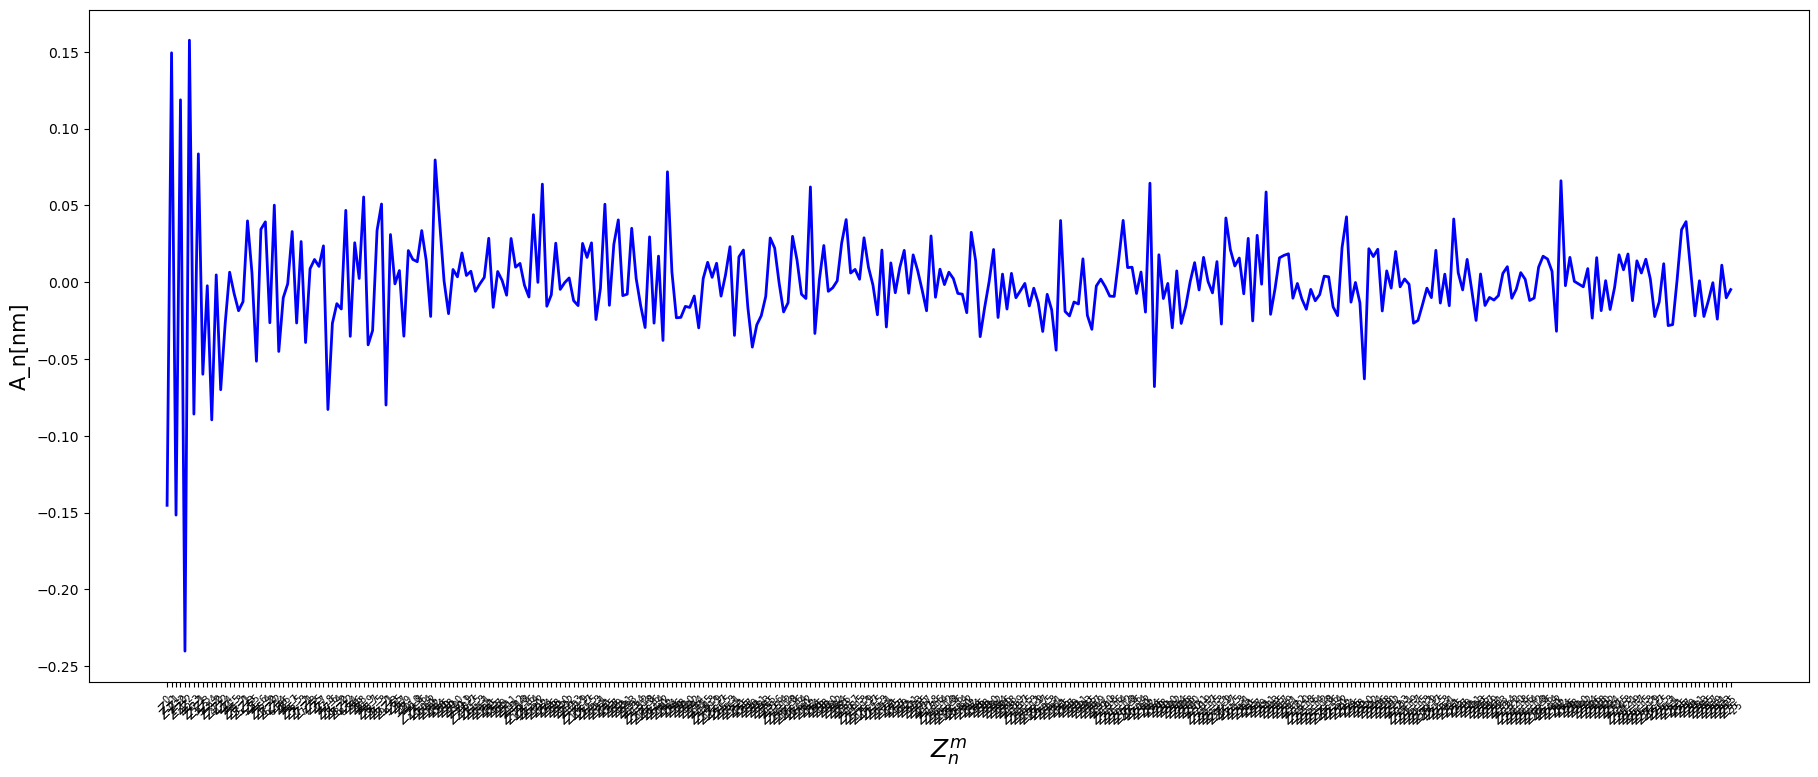

In [11]:
# plot amplitudes vs z_nm 
a_n_plot(a_n,order)

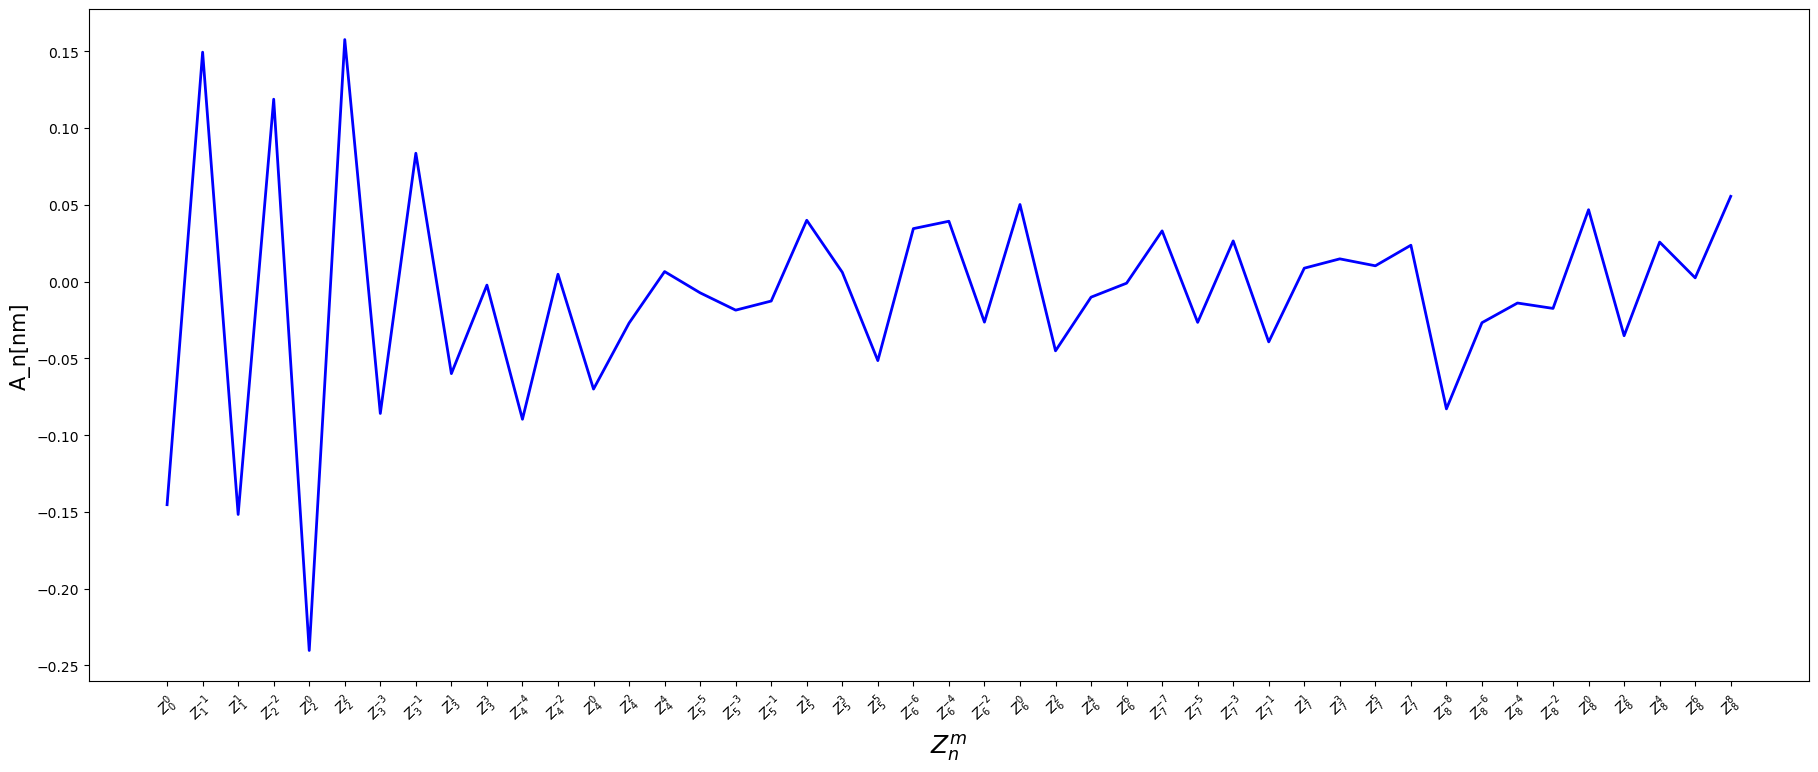

In [12]:
# basis
basis_8 = Zernikes(1131,0.15,8)
# coeff
a_n_8 = coeff_An_zernike(measured_map,basis_8)
# a_n plot
a_n_plot(a_n_8,order=8)

### Display the measured map using the basis

In [13]:
# create a 2D array with zeros, mirror map shape
map_test = np.zeros(basis[0].shape)

# linear combination of coeff and Zernike basis up to order n
for i,j in enumerate(a_n):
    map_ = a_n[i]*basis[i]
    map_test+=map_

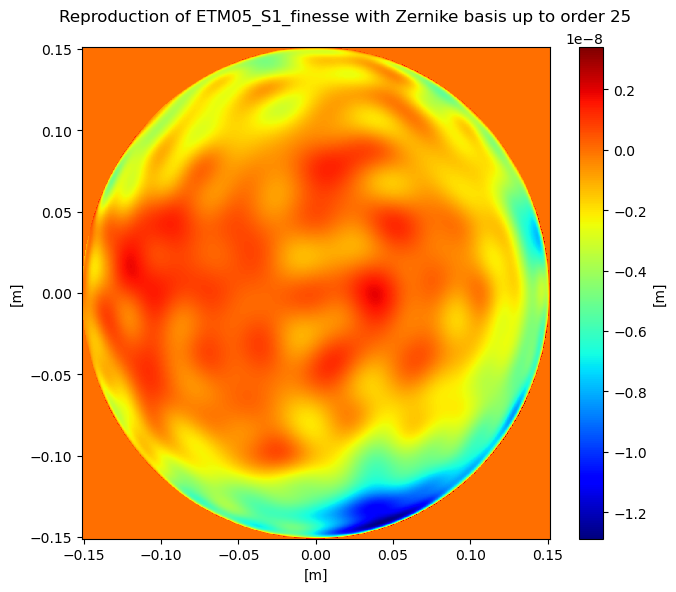

In [33]:
# reproduced map plot test
                                                                                              
x,y=np.meshgrid(x_range,x_range,sparse=True)
# plot real map
plt.figure(figsize=(7,6))
plt.pcolormesh(x,y,map_test*1e-8,cmap='jet')
plt.xlabel('[m]')
plt.ylabel('[m]')
plt.suptitle(f'Reproduction of {fname} with Zernike basis up to order {order}')
plt.tight_layout()
# color bar
cb = plt.colorbar()                 
cb.set_label("[m]")   
plt.savefig(f'zernike_{fname}.png')
plt.show()
# note that the cmap range is different i the reproduced map that in the real map